In [1]:
import os
import re
import sys
import glob
import pickle
import tables
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from comet_ml.api import API, APIExperiment
from comet_ml.query import Tag

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *
import pypan.utils

#### Find the best experiment given a set of tags

In [2]:
api = API(api_key = os.environ['COMET_API_KEY'])
workspace = 'danielelinaro'
project_name = 'inertia'
D = 2
DZA = 60
network_name = 'IEEE39'
inertia_units = 'GW s'
area_ID = 1
# inertia of generator 1
H_G1 = 500 # [s]
# the bus(es) where the stochastic load is connected
stoch_load_bus_IDs = [3]
stoch_load_bus_list = 'stoch_load_bus_' + '-'.join(map(str, stoch_load_bus_IDs))
# the bus(es) used for recording: an empy list means that the corresponding experiment tag won't be used
rec_bus_IDs = []

query = Tag(network_name) & \
        Tag(f'D={D}') & \
        Tag(f'DZA={DZA}') & \
        Tag('1D_pipeline') & \
        Tag(stoch_load_bus_list) & \
        Tag(f'H_G1_{H_G1}') & \
        Tag(f'area{area_ID}')

if len(rec_bus_IDs) > 1:
    rec_bus_list = 'buses_' + '-'.join(map(str, rec_bus_IDs))
    query &= Tag(rec_bus_list)

experiments = api.query(workspace, project_name, query, archived=False)
experiment_IDs = []
MAPE = []
val_loss = []
tags =  []
for experiment in experiments:
    ID = experiment.id
    experiment_IDs.append(ID)
    sys.stdout.write(f'Downloading data for experiment ID {ID}... ')
    metrics = experiment.get_metrics()
    sys.stdout.write('done.\n')
    val_loss.append(np.array([float(m['metricValue']) for m in metrics if m['metricName'] == 'val_loss']))
    has_MAPE = False
    for m in metrics:
        if m['metricName'] == 'mape_prediction':
            val = m['metricValue']
            try:
                MAPE.append(float(val))
            except:
                MAPE.append(list(map(float, [v for v in val[1:-1].split(' ') if len(v)])))
            has_MAPE = True
            break
    tags.append(experiment.get_tags())
    print(f'  val_loss: {val_loss[-1].min():.4f}')
    if has_MAPE:
        print(f'      MAPE: {MAPE[-1]}%')
    else:
        print('      MAPE: [experiment not terminated]')
    print('      Tags: "{}"'.format('" "'.join(tags[-1])))
# idx = np.argmin(MAPE)
idx = np.argmin([loss.min() for loss in val_loss])
experiment_ID = experiment_IDs[idx]
MAPE = MAPE[idx]
val_loss = val_loss[idx]
tags = tags[idx]
print(f'The best experiment is {experiment_ID[:6]} (val_loss = {val_loss.min():.4f}, MAPE = {MAPE}%).')

  val_loss: 0.0730
      MAPE: 0.6607083678245544%
      Tags: "1D_pipeline" "area1" "buses_3-14" "D=2" "DZA=60" "H_G1_500" "IEEE39" "neural_network" "ReLU_none" "stoch_load_bus_3"
  val_loss: 0.0828
      MAPE: 0.7656754851341248%
      Tags: "1D_pipeline" "area1" "buses_3-14-17" "D=2" "DZA=60" "H_G1_500" "IEEE39" "neural_network" "ReLU_none" "stoch_load_bus_3"
The best experiment is ff59cc (val_loss = 0.0730, MAPE = 0.6607083678245544%).


In [3]:
experiments_path = '../experiments/neural_network/'
checkpoint_path = experiments_path + experiment_ID + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
network_parameters = pickle.load(open(experiments_path + experiment_ID \
                                      + '/parameters.pkl', 'rb'))
epochs = [int(os.path.split(file)[-1].split('.')[1].split('-')[0]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[epochs.index(np.argmin(val_loss) + 1)]
model = keras.models.load_model(best_checkpoint, compile=True)
data_dirs = ['..' + os.path.sep +
             os.path.sep.join([d for d in data_dir.split(os.path.sep) if '{}' not in d]) +
             f'/H_G1_{H_G1}/stoch_load_bus_' + '-'.join(map(str, stoch_load_bus_IDs))
             for data_dir in network_parameters['data_dirs']]
# we need mean and standard deviation of the training set to normalize the data
x_train_mean = network_parameters['x_train_mean']
x_train_std  = network_parameters['x_train_std']
data_dir = data_dirs[0]
tmp = [re.findall('.*_bus', var_name)[0] for var_name in network_parameters['var_names']]
var_names_fmt = list(OrderedDict({k + '{}': [] for k in tmp}).keys())
if len(rec_bus_IDs) == 0:
    rec_bus_IDs = list(np.unique([int(re.findall('\d+', var_name)[0]) \
                                  for var_name in network_parameters['var_names']]))
    rec_bus_list = 'buses_' + '-'.join(map(str, rec_bus_IDs))
if not os.path.isdir(data_dir):
    raise Exception(f'{data_dir}: no such directory')
print(f'Loaded network from {best_checkpoint}.')
print(f'Data directory is {data_dir}.')
print(f'Variable names: {var_names_fmt}')

Loaded network from ../experiments/neural_network/ff59cc49801f49328074538fcae5407d/checkpoints/weights.0383-0.073004.h5.
Data directory is ../data/IEEE39/IEEE39_D=2_DZA=60.0/H_G1_500/stoch_load_bus_3.
Variable names: ['Pe_bus{}', 'Vd_bus{}', 'Vq_bus{}']


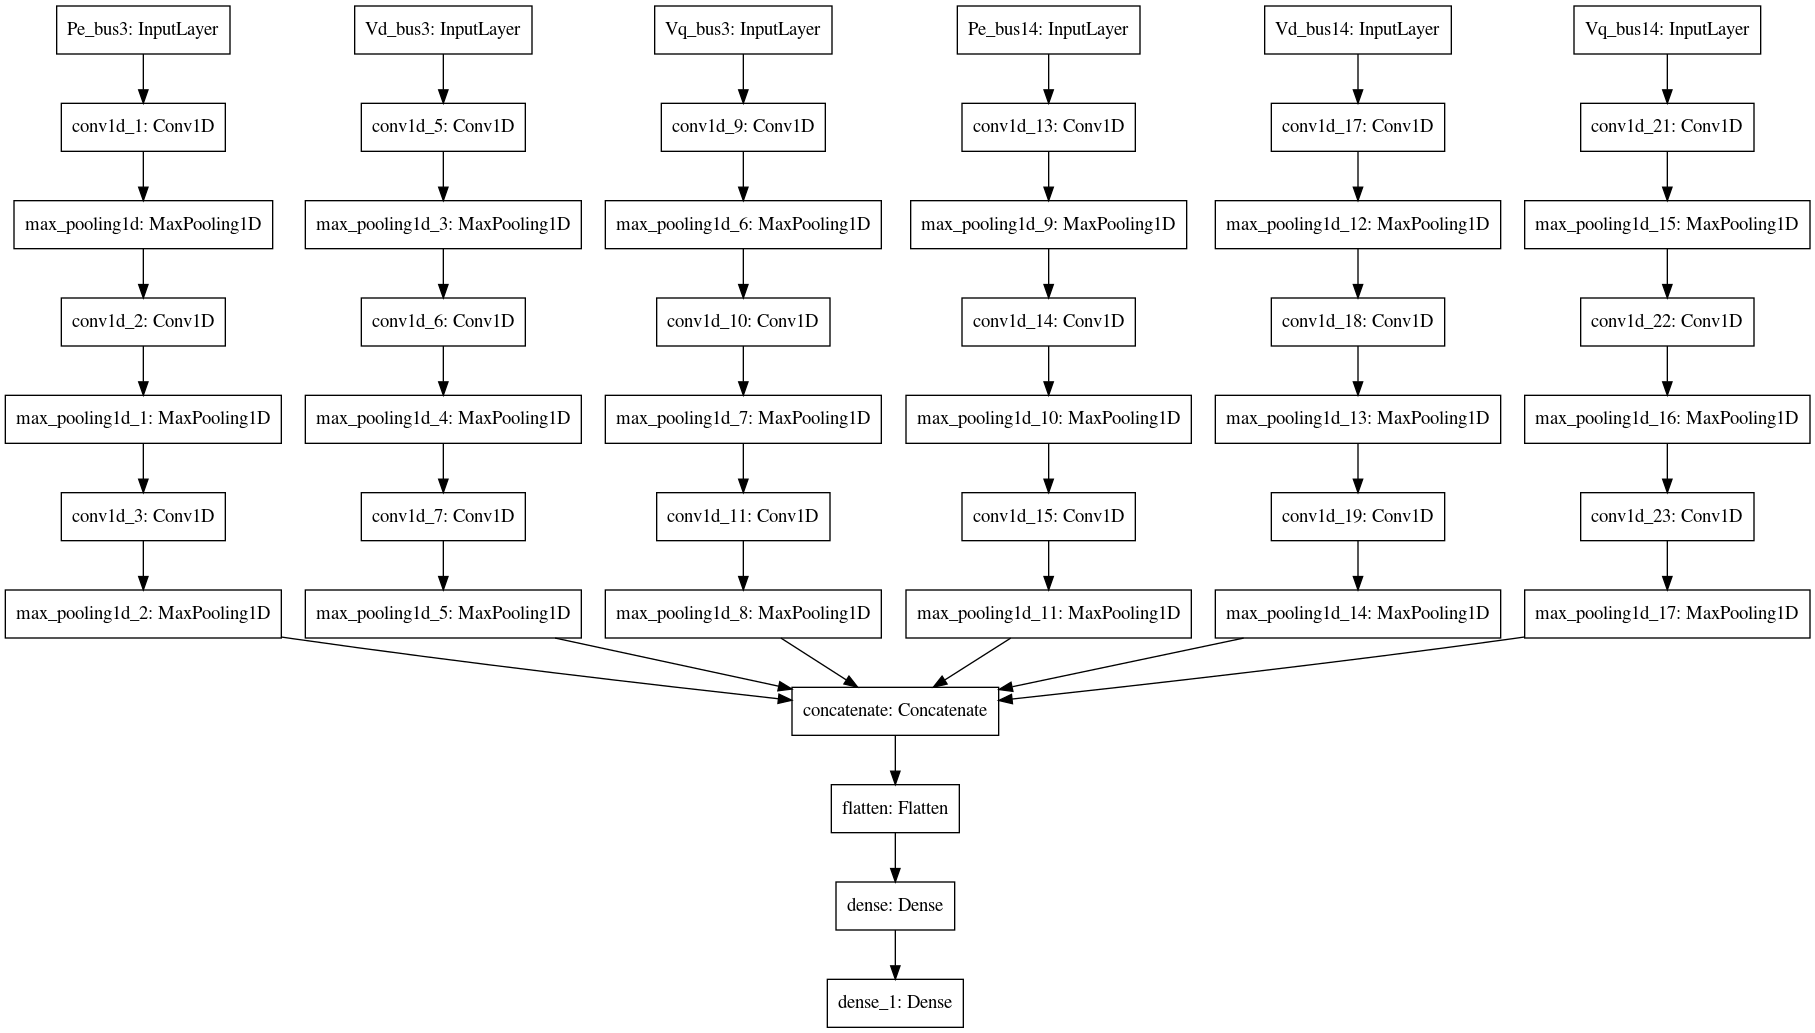

In [4]:
keras.utils.plot_model(model, show_shapes=False, dpi=96)

## Constant inertia

In [5]:
default_H = OrderedDict([
    ('Pg30', H_G1), ('Pg31', 30.3), ('Pg32', 35.8), ('Pg33', 28.6), ('Pg34', 26),
    ('Pg35', 34.8), ('Pg36', 26.4), ('Pg37', 24.3), ('Pg38', 34.5), ('Pg39', 42)

])
P_nom = {gen_ID: 100e6 for gen_ID in default_H}

generators_areas_map = [
    ['Pg31', 'Pg32', 'Pg39']
]

window_dur = 60
window_step = 10

H_values = [
    default_H,
    OrderedDict([
        ('Pg30', H_G1), ('Pg31', 34), ('Pg32', 40), ('Pg33', 28.6), ('Pg34', 26),
        ('Pg35', 34.8), ('Pg36', 26.4), ('Pg37', 24.3), ('Pg38', 34.5), ('Pg39', 46)

    ])
]
N_H = len(H_values)

area_inertia = []

data_normalized = []
inertia = []

var_names = [var_name.format(bus_ID) for bus_ID in np.unique(rec_bus_IDs) for var_name in var_names_fmt]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

for H in H_values:
    tmp_inertia = []
    for generator_IDs in generators_areas_map:
        tmp_inertia.append(np.sum([P_nom[gen_ID] * H[gen_ID] for gen_ID in generator_IDs]) * 1e-9)
    area_inertia.append(tmp_inertia)
    data_file = data_dir + '/ieee39_' + '_'.join(map(lambda h: f'{h:.3f}', H.values())) + '.h5'

    t, _, data_norm, data_sliding, _ = load_data_slide([data_file],
                                                        var_names,
                                                        data_mean,
                                                        data_std,
                                                        window_dur,
                                                        window_step,
                                                        add_omega_ref = False,
                                                        verbose = True)
    data_normalized.append(data_norm)
    dt = np.diff(t[:2])[0]
    time, HH, _ = predict(model, data_sliding, window_step, dt)
    inertia.append(HH)

Window size: 600 samples
Number of trials: 3540
Window size: 600 samples
Number of trials: 3540


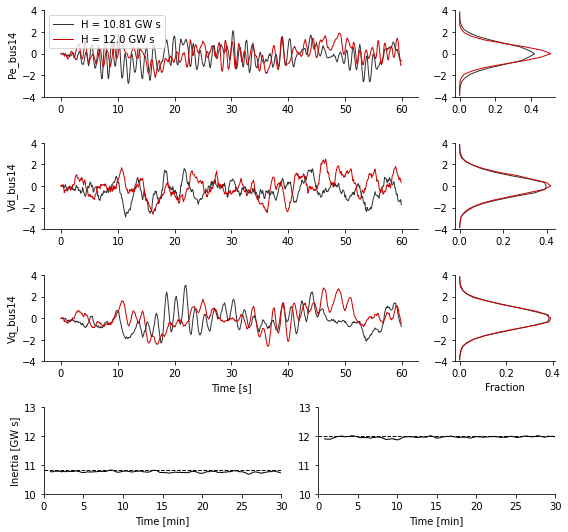

In [6]:
n_vars = len(var_names_fmt)
fig = plt.figure(figsize=(8, n_vars * 2.5))
gs = fig.add_gridspec(n_vars+1, 4)
ax = []
for i in range(n_vars):
    ax.append([fig.add_subplot(gs[i, :3]), fig.add_subplot(gs[i, 3])]),
ax.append([fig.add_subplot(gs[-1, :2]), fig.add_subplot(gs[-1, 2:])])

col = [[.2,.2,.2], [.8,0,0], [0,.7,0]]

bus_ID = rec_bus_IDs[1]

idx = t < 60
for i in range(N_H):
    for j,var_name in enumerate(var_names_fmt):
        key = var_name.format(bus_ID)
        value = data_normalized[i][key]
        n,edges = np.histogram(value, bins=25, range=(-4,4), density=True)
        ax[j][0].plot(t[idx], value[idx], color=col[i], lw=1, label=f'H = {area_inertia[i][0]} {inertia_units}')
        ax[j][1].plot(n, edges[:-1] + np.diff(edges[:2])[0] / 2, color=col[i], lw=1)
        for a in ax[j]:
            a.set_ylim([-4,4])
        ax[j][0].set_ylabel(key)
    ax[-1][i].plot(time / 60, inertia[i], 'k', lw=1)
    ax[-1][i].plot(time[[0,-1]] / 60, area_inertia[i][0] + np.zeros(2), 'k--', lw=1)
    ax[-1][i].set_ylim([10, 13])
    ax[-1][i].set_xlabel('Time [min]')

for a in ax:
    for side in 'right','top':
        for i in range(2):
            a[i].spines[side].set_visible(False)

ax[0][0].legend(loc='best')
ax[-1][0].get_shared_x_axes().join(ax[-1][0], ax[-1][1])

ax[-1][0].set_xlim([0,30])
ax[-1][0].set_ylabel(f'Inertia [{inertia_units}]')
ax[-2][0].set_xlabel('Time [s]')
ax[-2][1].set_xlabel('Fraction')
fig.tight_layout()
output_filename = f'{network_name}_area{area_ID}_H_G1={H_G1}_' + \
    f'rec_buses={rec_bus_list}_load_buses={stoch_load_bus_list}_const_H.pdf'
fig.savefig(output_filename)

## Step of inertia with transient

In [7]:
H_values = [
    OrderedDict([
        ('Pg30', H_G1), ('Pg31', 20), ('Pg32', 28), ('Pg33', 28.6), ('Pg34', 26),
        ('Pg35', 34.8), ('Pg36', 26.4), ('Pg37', 24.3), ('Pg38', 34.5), ('Pg39', 36)

    ]),
    OrderedDict([
        ('Pg30', H_G1), ('Pg31', 42), ('Pg32', 46), ('Pg33', 28.6), ('Pg34', 26),
        ('Pg35', 34.8), ('Pg36', 26.4), ('Pg37', 24.3), ('Pg38', 34.5), ('Pg39', 50)

    ])
]

H = []
for H_val in H_values:
    for generators in generators_areas_map:
        H.append(np.sum([H_val[gen_id] * P_nom[gen_id] for gen_id in generators]) * 1e-9)

data_file = data_dir + '/' + network_name.lower()
for gen_id in H_values[0]:
    data_file += '_' + '-'.join(map(lambda h: f'{h:.3f}', np.unique([H[gen_id] for H in H_values])))
data_file += '.h5'

window_dur = 60
window_step = 10

var_names = [var_name.format(bus_ID) for bus_ID in rec_bus_IDs for var_name in var_names_fmt]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

t, _, data_normalized, data_sliding, _ = load_data_slide([data_file],
                                                         var_names,
                                                         data_mean,
                                                         data_std,
                                                         window_dur,
                                                         window_step,
                                                         add_omega_ref = False,
                                                         verbose = True)

dt = np.diff(t[:2])[0]
time, inertia, _ = predict(model, data_sliding, window_step, dt)

Window size: 600 samples
Number of trials: 3540


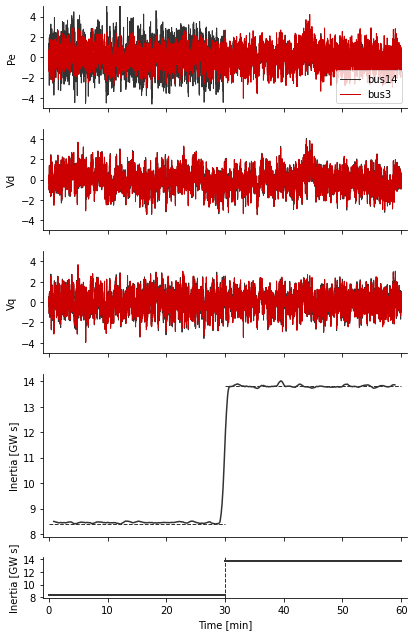

In [8]:
fig = plt.figure(figsize = (6,9))
gs = fig.add_gridspec(2 * n_vars + 3 + 1, 1)
ax = []
for i in range(n_vars):
    ax.append(fig.add_subplot(gs[i*2:(i+1)*2]))
ax.append(fig.add_subplot(gs[-4:-1,0]))
ax.append(fig.add_subplot(gs[-1,0]))

ds = 5
for i,var_name in enumerate(var_names_fmt):
    for j,bus_id in enumerate(rec_bus_IDs[::-1]):
        ax[i].plot(t[::ds] / 60, data_normalized[var_name.format(bus_id)][::ds],
                   color=col[j], lw=1, label=f'bus{bus_id}')
    ax[i].set_ylim([-5,5])
    ax[i].set_ylabel(var_name.split('_')[0])

ylim = [H[0] - 0.5, H[1] + 0.5]
ax[-2].plot(time[::ds] / 60, inertia[::ds,0], color=col[0])
ax[-2].set_ylim(ylim)
ax[-2].plot([0, 30], H[0] + np.zeros(2), '--', color=col[0], lw=1)
ax[-2].plot([30, 60], H[1] + np.zeros(2), '--', color=col[0], lw=1)

ax[-1].plot([0, 30], H[0] + np.zeros(2), '-', color=col[0], lw=2)
ax[-1].plot([30, 60], H[1] + np.zeros(2), '-', color=col[0], lw=2)
ax[-1].plot(30 + np.zeros(2), ylim, '--', color=col[0], lw=1)
ax[-1].set_ylim(ylim)
ax[-1].set_yticks(np.arange(8,15,2))
ax[-1].set_xlabel('Time [min]')

ax[0].legend(loc='lower right')

for a in ax:
    a.set_xlim([-1,61])
    for side in 'right', 'top':
        a.spines[side].set_visible(False)
    if a != ax[-1]:
        a.set_xticklabels([])

ax[-2].set_ylabel(f'Inertia [{inertia_units}]')
ax[-1].set_ylabel(f'Inertia [{inertia_units}]')

fig.tight_layout()
output_filename = f'{network_name}_area{area_ID}_H_G1={H_G1}_' + \
    f'rec_buses={rec_bus_list}_load_buses={stoch_load_bus_list}_step_H.pdf'
fig.savefig(output_filename)